# SSIM = structural similarity index
- Because it worked good for degradation methods including white noise and Gaussian blur according to [this paper](https://mediatum.ub.tum.de/doc/1183511/1183511.pdf).

In [1]:
# !pip install --upgrade scikit-image

Requirement already up-to-date: scikit-image in c:\users\alexander\anaconda3\lib\site-packages (0.16.2)


In [2]:
# !pip install --upgrade imutils

  Created wheel for imutils: filename=imutils-0.5.3-py3-none-any.whl size=25860 sha256=5bd7b67613d853bd1ec37b97a7b9e1a3b42f5f81f37e795d3b230035ecb3fc31
  Stored in directory: c:\users\alexander\appdata\local\pip\cache\wheels\fc\9c\6d\1826267c72afa51b564c9c6e0f66abc806879338bc593a2270
Successfully built imutils


Code is based on [this tutorial](https://www.pyimagesearch.com/2017/06/19/image-difference-with-opencv-and-python/)

In [27]:
# import the necessary packages
import numpy as np
import argparse
import imutils
import cv2
import os

from scipy.ndimage.filters import gaussian_filter as __gaussian_filter
from scipy.ndimage.filters import convolve as __convolve
from scipy.ndimage.filters import correlate as __correlate
from scipy.fftpack import fftshift as __fftshift
from skimage.metrics import structural_similarity as compare_ssim
from skimage.io import imshow

In [28]:
reference_path = "images/reference/I15.BMP"
distorted_path = "images/distorted/"

imageA = cv2.imread(reference_path)
# convert the images to grayscale
grayA = cv2.cvtColor(imageA, cv2.COLOR_BGR2GRAY)

In [44]:
# compute the Structural Similarity Index (SSIM) between the two
# images, ensuring that the difference image is returned
for name in os.listdir(distorted_path):
    if name[-4:] == ".bmp":
        imageB = cv2.imread(distorted_path + name)
        grayB = cv2.cvtColor(imageB, cv2.COLOR_BGR2GRAY)
        (score, diff) = compare_ssim(grayA, grayB, full=True)
        print("Noise type: {}, SSIM: {}".format(name[4:-4], score))
diff = (diff * 255).astype("uint8")

Noise type: 01_1, SSIM: 0.8233764307852962
Noise type: 01_2, SSIM: 0.7130296724468163
Noise type: 01_3, SSIM: 0.5799287245795091
Noise type: 01_4, SSIM: 0.44197506880337795
Noise type: 02_1, SSIM: 0.9429379921102425
Noise type: 02_2, SSIM: 0.8949745480789925
Noise type: 02_3, SSIM: 0.8187215405576137
Noise type: 02_4, SSIM: 0.7075570389109082
Noise type: 03_1, SSIM: 0.8418999190934761
Noise type: 03_2, SSIM: 0.7382300236915557
Noise type: 03_3, SSIM: 0.6118631245996193
Noise type: 03_4, SSIM: 0.47006636401462587
Noise type: 04_1, SSIM: 0.9429972199703595
Noise type: 04_2, SSIM: 0.8997178035384814
Noise type: 04_3, SSIM: 0.8303658644356245
Noise type: 04_4, SSIM: 0.732605439060973
Noise type: 05_1, SSIM: 0.8203310353858954
Noise type: 05_2, SSIM: 0.6246279024056448
Noise type: 05_3, SSIM: 0.397478795592052
Noise type: 05_4, SSIM: 0.2139698449958133
Noise type: 06_1, SSIM: 0.8408962280407672
Noise type: 06_2, SSIM: 0.7164937302880445
Noise type: 06_3, SSIM: 0.5567253728348435
Noise type:

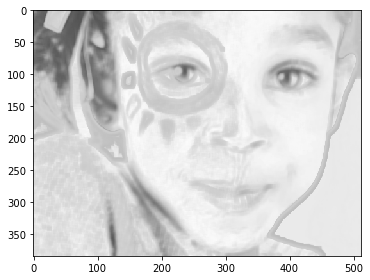

In [45]:
imshow(diff)

# WSNR = Weighted Signal to Noise Ratio
- because they achieved the highest correlation with the subjective test (test that used decisions of people) according to the [same paper](https://mediatum.ub.tum.de/doc/1183511/1183511.pdf).

Code is based on [this post](https://dsp.stackexchange.com/questions/44615/how-is-wsnr-weighted-signal-to-noise-ratio-defined).

In [31]:
def wsnr(reference, query):
    """Computes the Weighted Signal to Noise Ratio (WSNR) metric.

    value = wsnr(reference, query)

    inputs
    ----------
    reference: original image data.
    query    : modified image data to be compared.

    output
    ----------
    value    : wsnr value
    """
    def __genetate_meshgrid(x, y):
        f = lambda u: u / 2 + 0.5 - 1
        (H, W) = map(f, (x, y))
        return (H, W)

    def __create_complex_planes(x, y):
        (H, W) = __genetate_meshgrid(x, y)
        (xplane, yplane) = np.mgrid[-H:H + 1, -W:W + 1]
        return (xplane, yplane)

    def __get_evaluated_contrast_sensivity(plane):
        w = 0.7
        angle = np.angle(plane)
        return ((1.0 - w) / 2.0) * np.cos(4.0 * angle) + (1.0 + w) / 2.0

    def __get_radial_frequency(x, y):
        (xplane, yplane) = __create_complex_planes(x, y)
        nfreq = 60
        plane = (xplane + 1.0j * yplane) / x * 2.0 * nfreq
        s = __get_evaluated_contrast_sensivity(plane)
        radfreq = abs(plane) / s
        return radfreq

    def __generate_CSF(radfreq):
        a = -((0.114 * radfreq) ** 1.1)
        csf = 2.6 * (0.0192 + 0.114 * radfreq) * np.exp(a)
        f = radfreq < 7.8909
        csf[f] = 0.9809
        return csf

    def __weighted_fft_domain(ref, quer, csf):
        err = ref.astype('double') - quer.astype('double')
        err_wt = __fftshift(np.fft.fft2(err)) * csf
        im = np.fft.fft2(ref)
        return (err, err_wt, im)

    def __get_weighted_error_power(err_wt):
        return (err_wt * np.conj(err_wt)).sum()

    def __get_signal_power(im):
        return (im * np.conj(im)).sum()

    def __get_ratio(mss, mse):
        if mse != 0:
            ratio = 10.0 * np.log10(mss / mse)
        else:
            ratio = float("inf")
        return np.real(ratio)

    if not len(reference.shape) < 3:
        reference = __convert_to_luminance(reference)
        query = __convert_to_luminance(query)
    size = reference.shape
    (x, y) = (size[0], size[1])
    radfreq = __get_radial_frequency(x, y)
    csf = __generate_CSF(radfreq)
    (err, err_wt, im) = __weighted_fft_domain(reference, query, csf)
    mse = __get_weighted_error_power(err_wt)
    mss = __get_signal_power(im)
    ratio = __get_ratio(mss, mse)
    return ratio

In [32]:
reference_path = "images/reference/I15.BMP"
distorted_path = "images/distorted/"

imageA = cv2.imread(reference_path)
# convert the images to grayscale
grayA = cv2.cvtColor(imageA, cv2.COLOR_BGR2GRAY)

In [37]:
for name in os.listdir(distorted_path):
    if name[-4:] == ".bmp":
        imageB = cv2.imread(distorted_path + name)
        grayB = cv2.cvtColor(imageB, cv2.COLOR_BGR2GRAY)
        wsnr_score = wsnr(grayA, grayB)
        print("Noise type: {}, WSNR: {}".format(name[4:-4], wsnr_score))

Noise type: 01_1, WSNR: 38.355373835069905
Noise type: 01_2, WSNR: 35.21407034117885
Noise type: 01_3, WSNR: 31.93242969458835
Noise type: 01_4, WSNR: 28.617529058073934
Noise type: 02_1, WSNR: 42.47074864067969
Noise type: 02_2, WSNR: 39.155414486868146
Noise type: 02_3, WSNR: 35.71386146697326
Noise type: 02_4, WSNR: 32.152704036574505
Noise type: 03_1, WSNR: 31.681473739897964
Noise type: 03_2, WSNR: 28.568830618643027
Noise type: 03_3, WSNR: 25.631239995475724
Noise type: 03_4, WSNR: 22.595275784389766
Noise type: 04_1, WSNR: 40.61505830722205
Noise type: 04_2, WSNR: 37.10999626970206
Noise type: 04_3, WSNR: 33.35442630016566
Noise type: 04_4, WSNR: 29.524055845962664
Noise type: 05_1, WSNR: 41.05629420669768
Noise type: 05_2, WSNR: 35.50387669342093
Noise type: 05_3, WSNR: 29.368785530445393
Noise type: 05_4, WSNR: 22.326792562365245
Noise type: 06_1, WSNR: 36.883484197689924
Noise type: 06_2, WSNR: 32.97143888734573
Noise type: 06_3, WSNR: 28.808414610585757
Noise type: 06_4, WSN